In [ ]:
!pip install fastai --upgrade -q

     |████████████████████████████████| 194kB 17.6MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import sys
from statistics import *
from zipfile import ZipFile
from sklearn import linear_model
from fastai import *
from fastai.basics import *
from fastai.vision import *
from fastai.vision.all import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!nvidia-smi

Tue Nov 17 23:00:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!cp /content/gdrive/My\ Drive/DS1_car_connection.zip /content/

In [ ]:
!unzip -qq DS1_car_connection.zip

In [ ]:
!ls /content/

DS1_car_connection  DS1_car_connection.zip  gdrive  __MACOSX  sample_data


# **Section 1: Data Preprocessing & Exploration** 

In [ ]:
def make_car_connection(file_name):
	return file_name.split("_")[0] # Returns make
def make_model_car_connection(file_name):
	return file_name.split("_")[0:2].join("_") # Returns make_model
def year_car_connection(file_name):
	return file_name.split("_")[2] # Returns year

In [ ]:
path_car_connection = "/content/DS1_car_connection"
files_car_connection = get_image_files(path_car_connection)
len_car_connection = len(files_car_connection)

files_car_connection_2000_2009 = []
labels_car_connection_2000_2009 = set()
files_car_connection_2010_2013 = []
labels_car_connection_2010_2013 = set()
files_car_connection_2014_2017 = []
labels_car_connection_2014_2017 = set()
files_car_connection_2018_2020 = []
labels_car_connection_2018_2020 = set()
for i in range(len_car_connection):
    year_i = int(year_car_connection(files_car_connection[i].name))
    if year_i >= 2000 and year_i <= 2009:
        labels_car_connection_2000_2009.add(make_car_connection(files_car_connection[i].name))
    elif year_i >= 2010 and year_i <= 2013:
        labels_car_connection_2010_2013.add(make_car_connection(files_car_connection[i].name))
    elif year_i >= 2014 and year_i <= 2017:
        labels_car_connection_2014_2017.add(make_car_connection(files_car_connection[i].name))
    elif year_i >= 2018 and year_i <= 2020:
        labels_car_connection_2018_2020.add(make_car_connection(files_car_connection[i].name))
common_labels = labels_car_connection_2000_2009.intersection(labels_car_connection_2010_2013).intersection(labels_car_connection_2014_2017).intersection(labels_car_connection_2018_2020)
for i in range(len_car_connection):
    year_i = int(year_car_connection(files_car_connection[i].name))
    make_i = make_car_connection(files_car_connection[i].name)
    if make_i in common_labels:
        if year_i >= 2000 and year_i <= 2009:
            files_car_connection_2000_2009.append(files_car_connection[i])
        elif year_i >= 2010 and year_i <= 2013:
            files_car_connection_2010_2013.append(files_car_connection[i])
        elif year_i >= 2014 and year_i <= 2017:
            files_car_connection_2014_2017.append(files_car_connection[i])
        elif year_i >= 2018 and year_i <= 2020:
            files_car_connection_2018_2020.append(files_car_connection[i])

In [ ]:
num_classes = len(common_labels)
print("Number of common labels:", num_classes)
print(common_labels)
print("Number of pictures in each category:")
print("files_car_connection_2000_2009: %d" %len(files_car_connection_2000_2009))
print("files_car_connection_2010_2013: %d" %len(files_car_connection_2010_2013))
print("files_car_connection_2014_2017: %d" %len(files_car_connection_2014_2017))
print("files_car_connection_2018_2020: %d" %len(files_car_connection_2018_2020))

Number of common labels: 12
{'Chrysler', 'Jeep', 'GMC', 'Aston Martin', 'Honda', 'Chevrolet', 'Ford', 'Land Rover', 'Mitsubishi', 'Acura', 'BMW', 'Lincoln'}
Number of pictures in each category:
files_car_connection_2000_2009: 1463
files_car_connection_2010_2013: 7859
files_car_connection_2014_2017: 9522
files_car_connection_2018_2020: 5894


In [ ]:
# [0]: training DS, [1]: validation DS
# Default batch size = 64
car_connection_DS_2000_2009 = ImageDataLoaders.from_name_func(
	path_car_connection, files_car_connection_2000_2009, make_car_connection, valid_pct=0, item_tfms=Resize(224),
    num_workers=0)
car_connection_DS_2010_2013 = ImageDataLoaders.from_name_func(
	path_car_connection, files_car_connection_2010_2013, make_car_connection, valid_pct=0.2, item_tfms=Resize(224),
    num_workers=0)
car_connection_DS_2014_2017 = ImageDataLoaders.from_name_func(
	path_car_connection, files_car_connection_2014_2017, make_car_connection, valid_pct=0.2, item_tfms=Resize(224),
    num_workers=0)
car_connection_DS_2018_2020 = ImageDataLoaders.from_name_func(
	path_car_connection, files_car_connection_2018_2020, make_car_connection, valid_pct=0.2, item_tfms=Resize(224),
    num_workers=0)
car_connection_DS_2010_2020 = ImageDataLoaders.from_name_func(
	path_car_connection, files_car_connection_2010_2013 + files_car_connection_2014_2017 + files_car_connection_2018_2020, make_car_connection, valid_pct=0, item_tfms=Resize(224),
    num_workers=0)

2000~2009:


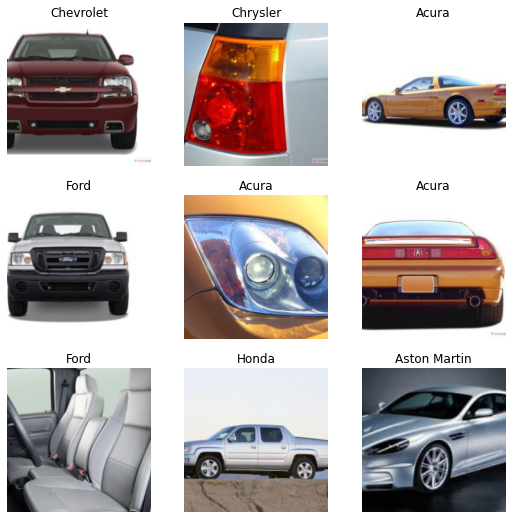

In [ ]:
print("2000~2009:")
car_connection_DS_2000_2009.show_batch()

2010~2013:


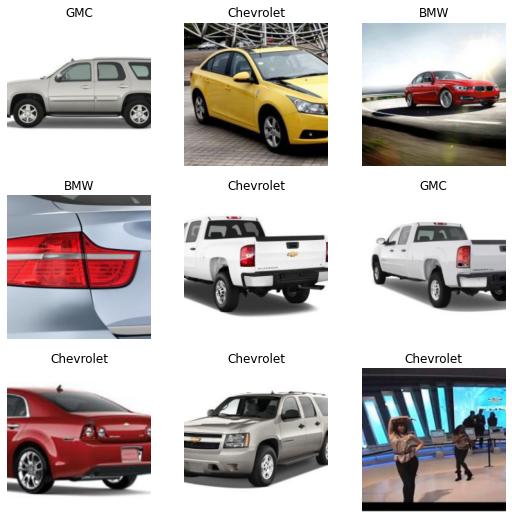

In [ ]:
print("2010~2013:")
car_connection_DS_2010_2013.show_batch()

2014~2017:


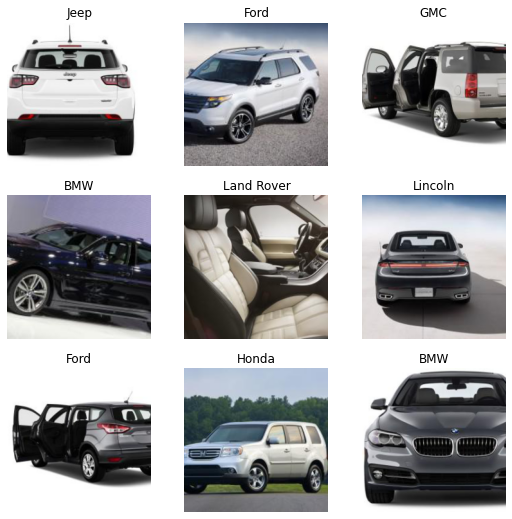

In [ ]:
print("2014~2017:")
car_connection_DS_2014_2017.show_batch()

2018~2020:


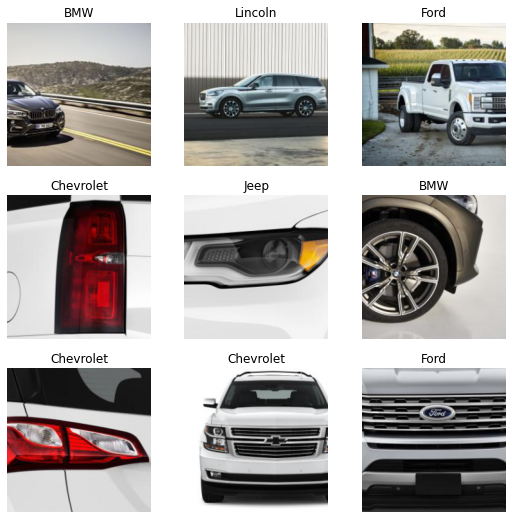

In [ ]:
print("2018~2020:")
car_connection_DS_2018_2020.show_batch()

# **Section 2: Training the Models**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_transform = resnet34(pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


**Subsection 2-1: Resnet + Final Layer Logistic Regression**

In [ ]:
def batch_logit(dataset, num_classes, feature_transform, device, num_passes=5):
    logit_model = linear_model.SGDClassifier(loss='log')
    with torch.no_grad():
        for epoch in range(num_passes):
            print("Pass number %d:" %epoch)
            for i, batch in enumerate(dataset):
                if i % 50 == 0:
                    print("Loading batch number %d..." %i)
                (pixels_batch, y_batch) = batch
                pixels_batch = pixels_batch.to(device) # Send input tensors to GPU if needed
                X_batch = feature_transform(pixels_batch)
                logit_model.partial_fit(X_batch.cpu(), y_batch.cpu(), range(num_classes))
    return logit_model

In [ ]:
resnet_logit_model = batch_logit(car_connection_DS_2010_2020[0], num_classes, resnet_transform, device)

Pass number 0:
Loading batch number 0...
Loading batch number 50...
Loading batch number 100...
Loading batch number 150...
Loading batch number 200...
Loading batch number 250...
Loading batch number 300...
Loading batch number 350...
Pass number 1:
Loading batch number 0...
Loading batch number 50...
Loading batch number 100...
Loading batch number 150...
Loading batch number 200...
Loading batch number 250...
Loading batch number 300...
Loading batch number 350...
Pass number 2:
Loading batch number 0...
Loading batch number 50...
Loading batch number 100...
Loading batch number 150...
Loading batch number 200...
Loading batch number 250...
Loading batch number 300...
Loading batch number 350...
Pass number 3:
Loading batch number 0...
Loading batch number 50...
Loading batch number 100...
Loading batch number 150...
Loading batch number 200...
Loading batch number 250...
Loading batch number 300...
Loading batch number 350...
Pass number 4:
Loading batch number 0...
Loading batch n

**Subsection 2-2: Resnet + Final Layer Invariant Risk Minimization**

For any mini-batch of size $2b$, `get_IRM_penalty` computes $\sum_{i = 1}^b \nabla_w \ell(w \cdot \Phi(X_{2i}^e), Y_{2i}^e)) |_{w = 1} \cdot \nabla_w \ell(w \cdot \Phi(X_{2i - 1}^e), Y_{2i - 1}^e)) |_{w = 1}$, which is an unbiased estimate for $\|\nabla_w R^e(w  \cdot \Phi) |_{w = 1} \|_2^2$ in the penalty term of IRM as long as the batch is scrambled beforehand.

In [ ]:
def get_IRM_penalty(losses, dummy_w):
  g1 = grad(losses[0::2].mean(), dummy_w, create_graph=True)[0] # Takes all even indices of losses
  g2 = grad(losses[1::2].mean(), dummy_w, create_graph=True)[0] # Takes all odd indices of losses
  return (g1*g2).sum()

`batch_IRM` minimizes $\sum_{e \in \mathcal{E}_{tr}} R^e(\Phi) + \lambda \|\nabla_w R^e(w  \cdot \Phi) |_{w = 1} \|_2^2$, where $\|\nabla_w R^e(w  \cdot \Phi) |_{w = 1} \|_2^2$ is approximated with `get_IRM_penalty`.

In [ ]:
def batch_IRM(datasets, num_classes, x_dim, feature_transform, device, penalty_multiplier, loss_function=null, num_passes=1000, learning_rate = 1e-9): 
  if loss_function is null:
    loss_function = torch.nn.CrossEntropyLoss(reduction="none")

  num_environments = len(datasets)

  phi = torch.nn.Parameter(torch.randn(x_dim, num_classes).to(device))
  dummy_w = torch.nn.Parameter(torch.Tensor([1.0]).to(device))

  opt = torch.optim.SGD([phi], lr=learning_rate)

  for epoch in range(num_passes):
    error = 0
    penalty = 0
    if epoch % 100 == 0:
      print("Pass number %d:" %epoch)
    for e in range(len(datasets)):
      if epoch % 100 == 0:
        print("Loading data from environment %d..." %e)
      for i, batch in enumerate(datasets[e]):
        (pixels_batch_e, y_batch_e) = batch
        pixels_batch_e = pixels_batch_e.to(device) # Send input tensors to GPU if needed
        with torch.no_grad():
          X_batch_e = feature_transform(pixels_batch_e)
        y_batch_e = y_batch_e.to(device)
        error_e = loss_function(X_batch_e @ phi * dummy_w, y_batch_e)
        error += error_e.mean()
        penalty += get_IRM_penalty(error_e, dummy_w)
        break
    opt.zero_grad() # Set the "gradient storage" of phi to zero
    loss = error + penalty_multiplier*penalty
    loss.backward() # Store the gradient of error + penalty_multiplier*penalty in the "gradient storage" of phi
    opt.step() # Increment phi by taking a step in the negative direction of the gradient stored

    if epoch % 100 == 0:
      print("Current loss = ", loss)
      # print(phi)

  return phi

In [ ]:
def resnet_IRM_model(X_batch, phi):
  return (X_batch @ phi).argmax(1)

In [ ]:
def tune_batch_IRM(datasets, valid_datasets, num_classes, x_dim, feature_transform, device, loss=null, num_passes=1000, learning_rate = 1e-9): 
  penalty_multipliers = [num_passes**1.4, num_passes**1.6, num_passes**1.8, num_passes**2, num_passes**2.2]
  best_phi = null
  best_accuracy = 0
  for penalty_multiplier in penalty_multipliers:
    print("penalty_multiplier = %f:" %penalty_multiplier)
    phi = batch_IRM(datasets, num_classes, x_dim, feature_transform, device, penalty_multiplier, loss, num_passes, learning_rate)
    num_datasets = len(valid_datasets)
    accuracies = []
    for e in range(num_datasets):
      accuracy_e = 0
      count_e = 0
      for i, batch in enumerate(valid_datasets[e]):
        (pixels_batch_e, y_batch_e) = batch
        pixels_batch_e = pixels_batch_e.to(device) # Send input tensors to GPU if needed
        with torch.no_grad():
          X_batch_e = feature_transform(pixels_batch_e)
        y_batch_pred_e = resnet_IRM_model(X_batch_e, phi)
        count_e += y_batch_e.shape[0]
        for j in range(y_batch_e.shape[0]):
          if y_batch_e[j] == y_batch_pred_e[j]:
            accuracy_e += 1
      accuracy_e = accuracy_e/count_e
      accuracies.append(accuracy_e)
    accuracy = mean(accuracies)
    print("Mean accuracy of validation datasets = %f" %accuracy)
    if accuracy > best_accuracy:
      best_phi = phi
      best_accuracy = accuracy
  return best_phi

In [ ]:
datasets = [car_connection_DS_2010_2013[0], car_connection_DS_2014_2017[0], car_connection_DS_2018_2020[0]]
valid_datasets = [car_connection_DS_2010_2013[1], car_connection_DS_2014_2017[1], car_connection_DS_2018_2020[1]]
x_dim = 1000
phi = tune_batch_IRM(datasets, valid_datasets, num_classes, x_dim, resnet_transform, device)

penalty_multiplier = 15848.931925:
Pass number 0:
Loading data from environment 0...
Loading data from environment 1...
Loading data from environment 2...
Current loss =  TensorImage(6.3224e+08, device='cuda:0', grad_fn=<AliasBackward>)
Pass number 100:
Loading data from environment 0...
Loading data from environment 1...
Loading data from environment 2...
Current loss =  TensorImage(2.0534e+08, device='cuda:0', grad_fn=<AliasBackward>)
Pass number 200:
Loading data from environment 0...
Loading data from environment 1...
Loading data from environment 2...
Current loss =  TensorImage(1.7228e+08, device='cuda:0', grad_fn=<AliasBackward>)
Pass number 300:
Loading data from environment 0...
Loading data from environment 1...
Loading data from environment 2...
Current loss =  TensorImage(1.4931e+08, device='cuda:0', grad_fn=<AliasBackward>)
Pass number 400:
Loading data from environment 0...
Loading data from environment 1...
Loading data from environment 2...
Current loss =  TensorImage(1

In [ ]:
phi

Parameter containing:
tensor([[-0.7930,  0.5972,  1.0197,  ...,  0.0649,  1.7382,  0.5742],
        [ 0.4681,  1.3157,  0.6798,  ..., -0.2739, -1.2424, -0.8830],
        [-1.9370,  1.7592,  0.1987,  ..., -1.2946,  0.6667, -0.8986],
        ...,
        [ 1.1806, -0.9872, -0.3404,  ..., -0.6844, -0.9763,  0.2455],
        [-0.1520,  0.0575, -0.3702,  ...,  0.6414, -0.4797,  0.0260],
        [-0.2431, -0.6420,  1.2481,  ...,  1.4055,  0.2747, -2.3750]],
       device='cuda:0', requires_grad=True)

**Subsection 2-3: Multilayer Resnet Finetuning**

In [ ]:
resnet_multilayer_finetune = cnn_learner(car_connection_DS_2010_2020, resnet34, metrics=error_rate)
resnet_multilayer_finetune.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.917298,None,None,02:47


/usr/local/lib/python3.6/dist-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,error_rate,time
0,0.834018,None,None,03:23


# **Section 3: Results**

In [ ]:
def get_confusion_matrix(dataset, num_classes, model, feature_transform, device):
  confusion_matrix = np.zeros((num_classes, num_classes)) # True class x Predicted class
  with torch.no_grad():
    for i, batch in enumerate(dataset):
      if i % 20 == 0:
        print("Loading batch number %d..." %i)
      (pixels_batch, y_batch) = batch
      pixels_batch = pixels_batch.to(device) # Send input tensors to GPU if needed
      X_batch = feature_transform(pixels_batch)
      y_pred = model(X_batch)
      for j in range(y_batch.shape[0]):
        confusion_matrix[y_batch[j], y_pred[j]] += 1
  return confusion_matrix

**Subsection 3-1: Resnet + Final Layer Logistic Regression**

In [ ]:
resnet_logit_CM = get_confusion_matrix(car_connection_DS_2000_2009[0], num_classes, lambda x: resnet_logit_model.predict(x.cpu()), resnet_transform, device)

Loading batch number 0...
Loading batch number 20...


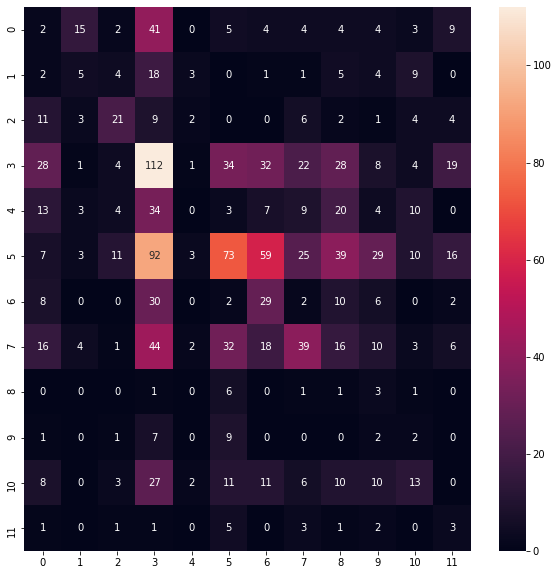

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(resnet_logit_CM.astype(int), annot=True, fmt='d')

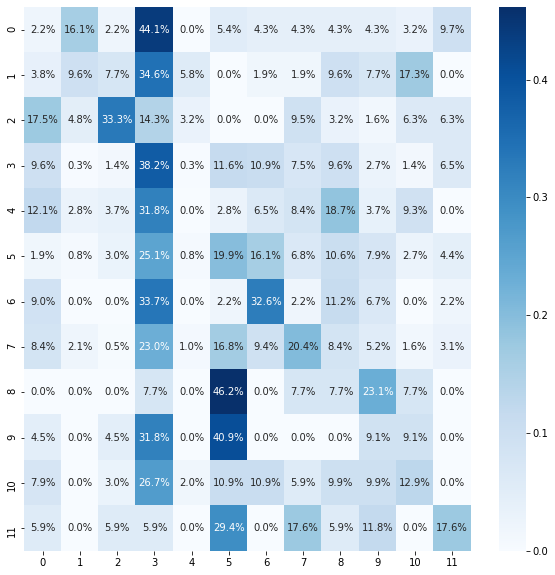

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(resnet_logit_CM/np.sum(resnet_logit_CM, axis=1).reshape((12, 1)), annot=True, fmt='.1%', cmap='Blues')

In [ ]:
resnet_logit_accuracy_overall = np.sum(np.diag(resnet_logit_CM))/np.sum(resnet_logit_CM)
print("Overall accuracy of resnet logit: %f" %resnet_logit_accuracy_overall)

Overall accuracy of resnet logit: 0.213068


**Subsection 3-2: Resnet + Final Layer Invariant Risk Minimization**

In [ ]:
resnet_IRM_CM = get_confusion_matrix(car_connection_DS_2000_2009[0], num_classes, lambda x: resnet_IRM_model(x, phi), resnet_transform, device)

Loading batch number 0...
Loading batch number 20...


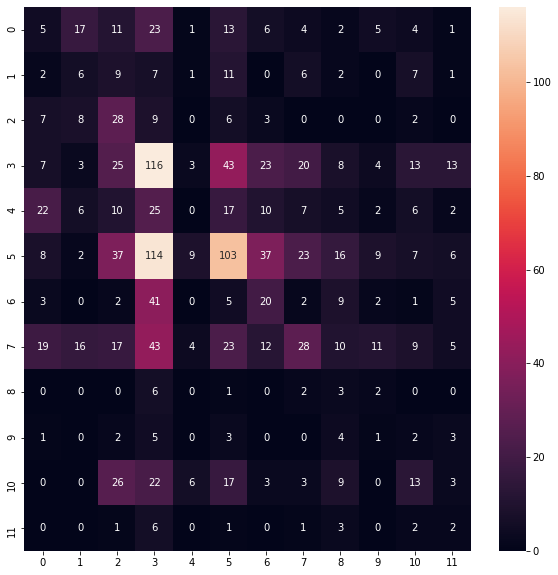

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(resnet_IRM_CM.astype(int), annot=True, fmt='d')

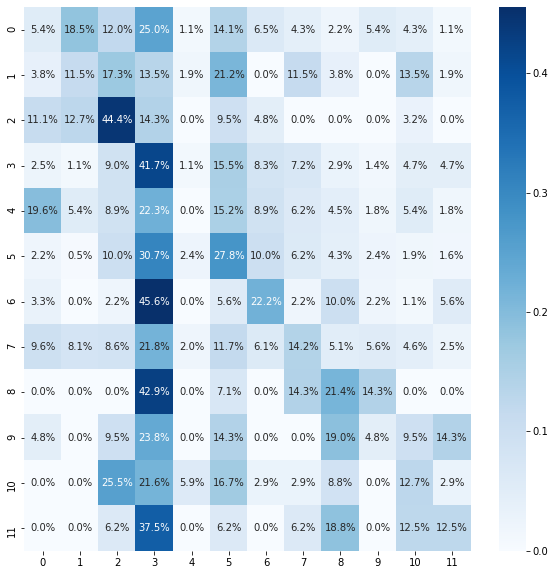

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(resnet_IRM_CM/np.sum(resnet_IRM_CM, axis=1).reshape((12, 1)), annot=True, fmt='.1%', cmap='Blues')

In [ ]:
resnet_IRM_accuracy_overall = np.sum(np.diag(resnet_IRM_CM))/np.sum(resnet_IRM_CM)
print("Overall accuracy of resnet IRM: %f" %resnet_IRM_accuracy_overall)

Overall accuracy of resnet IRM: 0.230824


**Subsection 3-3: Multilayer Resnet Finetuning**

In [ ]:
def resnet_multilayer_predict_batch(model, X_batch, device):
  batch_size = X_batch.shape[0]
  # y_pred = torch.zeros([batch_size], dtype=torch.int32)
  X_batch = X_batch.to(device)
  y_pred = model.model(X_batch).argmax(1)
  return y_pred

In [ ]:
resnet_multilayer_CM = get_confusion_matrix(car_connection_DS_2000_2009[0], num_classes, lambda x: resnet_multilayer_predict_batch(resnet_multilayer_finetune, x, device), lambda x: x, device)

Loading batch number 0...
Loading batch number 20...


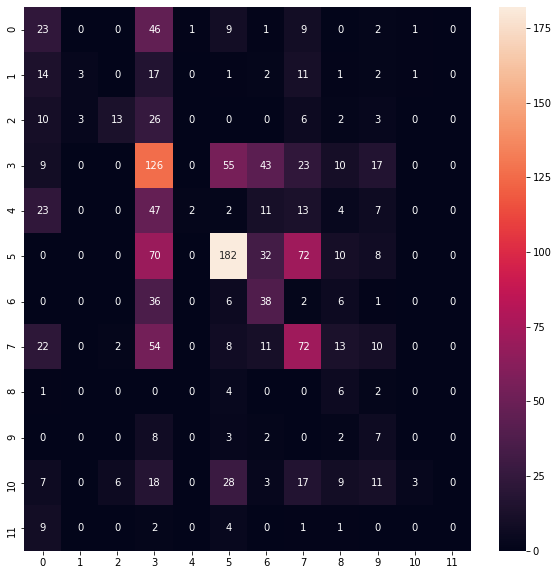

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(resnet_multilayer_CM.astype(int), annot=True, fmt='d')

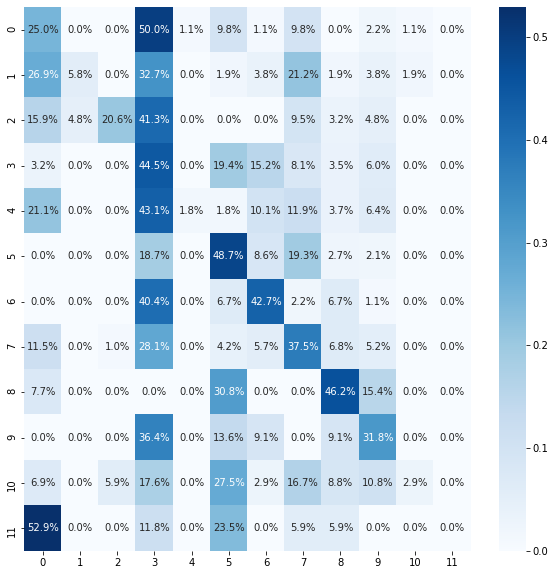

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(resnet_multilayer_CM/np.sum(resnet_multilayer_CM, axis=1).reshape((12, 1)), annot=True, fmt='.1%', cmap='Blues')

In [ ]:
resnet_multilayer_accuracy_overall = np.sum(np.diag(resnet_multilayer_CM))/np.sum(resnet_multilayer_CM)
print("Overall accuracy of resnet multilayer finetuning: %f" %resnet_multilayer_accuracy_overall)

Overall accuracy of resnet multilayer finetuning: 0.337358
